[](https://)<a target="_blank" href="https://colab.research.google.com/github/tuankhoin/CO3005-PPL/blob/main/Week_3_Syntax.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Ho Chi Minh University of Technology (HCMUT)

CO3005 - Principles of Programming Languages

# Week 3 - Syntax Analysis

Before you start, here is a table of some common ANTLR token namings.

You can name something else for them obviously, but this will help when you are looking at a sample ANTLR code.

| Token Name   | Example(s)      | Description                                |
|--------------|-----------------|--------------------------------------------|
| ADDOP        | +, -            | Addition or subtraction operators          |
| MULOP        | *, /, %         | Multiplication, division, modulo operators |
| ASSIGN       | =               | Assignment operator                        |
| EQOP         | ==              | Equality comparison                        |
| RELOP        | <, >, <=, >=    | Relational comparison operators            |
| ANDOP        | &&              | Logical AND                                |
| OROP         | \|\|              | Logical OR                                 |
| NOTOP        | !               | Logical NOT                                |
| INCOP        | ++              | Increment operator                         |
| DECOP        | --              | Decrement operator                         |
| IDENTIFIER   | foo, bar123     | Variable/function names                    |
| INTLIT       | 42, 0, 9999     | **Integer literal** (whole number)         |
| FLOATLIT     | 3.14, 0.5       | Floating-point literal                     |
| STRINGLIT    | "hello"         | String literal                             |
| CHARLIT      | 'a', 'Z'        | Character literal                          |
| IF           | if              | Conditional keyword                        |
| ELSE         | else            | Conditional keyword                        |
| WHILE        | while           | Loop keyword                               |
| FOR          | for             | Loop keyword                               |
| RETURN       | return          | Function return keyword                    |
| SEMI         | ;               | Statement terminator                       |
| COMMA        | ,               | Separator                                  |
| LPAREN       | (               | Left parenthesis                           |
| RPAREN       | )               | Right parenthesis                          |
| LBRACE       | {               | Left brace                                 |
| RBRACE       | }               | Right brace                                |

## RegEx to ANTLR

- In ANTLR, you wrap literal strings in single quotes (`+`, `if`), while character classes use square brackets (`[0-9]`).
- Quantifiers (`?`, `*`, `+`) work the same way as regex.


| Concept / Pattern   | Regex Example     | ANTLR Equivalent Example       |
|---------------------|------------------|--------------------------------|
| Literal string      | `"hello"`        | 'hello'                        |
| Alternation         | `cat\|dog`        | 'cat' \| 'dog'                  |
| Zero or more        | `a*`             | 'a'*                           |
| One or more         | `a+`             | 'a'+                           |
| Optional            | `a?`             | 'a'?                           |
| Grouping            | `(ab\|cd)`        | ('ab' \| 'cd')                  |
| Any char            | `.`              | .                              |
| Escape sequence     | `\n`             | '\n'                           |
| Digit shorthand     | `\d`             | [0-9]                          |
| Word char shorthand | `\w`             | [a-zA-Z0-9_]                   |
| Whitespace shorthand| `\s`             | [ \t\r\n]                      |
| Negated char class        | `[^a-z]`           | ~[a-z]                         | Matches any char *except* a–z. |
| Negated single literal    | `[^+]`             | ~'+'                           | Matches any char *except* '+'. |
| Normal char class         | `[a-z0-9]`         | [a-z0-9]                       | Works the same in both. |

## 1. Role of Syntax Analysis in a Compiler

<img src="https://github.com/tuankhoin/CO3005-PPL/blob/main/assets/w3.JPG?raw=true" alt="drawing" width="500"/>

Syntax analysis is the **second phase** of the compiler front end.

Its responsibilities are to:

* Read the **sequence of tokens** produced by the lexical analyzer
* Determine whether the token sequence conforms to the **syntactic structure** of the language
* Construct a **parse tree** or **abstract syntax tree (AST)**
* Report **syntax errors** in a meaningful way

Pipeline view:

```
Source Program
   ↓
Lexical Analyzer -> Last week
   ↓
Syntax Analyzer -> You are here
   ↓
Parse Tree -> You are also here
and AST
   ↓
Semantic Analysis
```

The parser does **not** check meaning (types, scope, values)—only structure.

* Lexer: **characters → tokens**
* Parser: **tokens → structure (parse tree / AST)** + reports syntax errors

---

## 2. Why we even call it “grammar”

Natural languages and programming languages both have:

* **Vocabulary** (words / tokens)
* **Rules to form valid sentences** (syntax)

#### **Natural language grammar (real world):**

```
Did you went there today? -> Where is 'there'?

'Thằng Tây đi với thằng Tày' -> Who are 'thằng Tây' and 'thằng Tày'?
```

* Often **ambiguous** and context-dependent
* Ambiguity resolved with background knowledge, tone, context.

#### **Programming language grammar:**

```
a = 5;
c = a + b; -> Syntax error: Where is b?
```

* Must: **precise, machine-checkable**
* Ambiguity is dangerous: it can make program ill-defined.

---

## 3. Why not RegEx?

- Regex/DFA/NFA has **no memory** beyond a finite state.
- Nested structures: **need memory** because you must “remember how many opens you’ve seen” to match closes:

  * Parentheses / blocks:

    ```
    begin ... begin ... end ... end
    ```
  * Balanced parentheses:

    ```
    ( ( ) ( ( ) ) )
    ```
  * Recursive expressions:

    ```
    <expr> ::= <expr> + <expr>
    ```

To validate this, you need a **counter**. A finite automaton only has states, inputs and transitions.
* **Regex/Finite Automata** → good for tokens (IDs, ints, keywords)
* **CFG/Parsing** → needed for nested, recursive syntax (expressions, blocks, if/else nesting)

---

## 4. Context-Free Grammars (CFG)

A **Context-Free Grammar (CFG)** is used to describe programming language syntax.

A CFG consists of:

* **Terminals (T)**: tokens (e.g. `ID`, `INTLIT`, `ADDOP`)
* **Non-terminals (N)**: syntactic categories (e.g. `<exp>`, `<stmt>`)
* **Start symbol (S)**: root of the grammar
* **Productions (P)**: rules of the form `X → α`

In a CFG, a production rule:

> `X → α`

means:

* `X` is a **non-terminal** (a syntactic category like `<exp>` or `<stmt>`)
* `α` is a sequence of **terminals and/or non-terminals**
* It reads as:
  **“An `X` can be replaced by `α`.”**

This is not “assignment” like in code. It is a **rewrite rule** used to generate or recognize valid structures.

Example:

```
<term> → <term> MULOP <factor>
```

Means: a term may be “a term multiplied by a factor” (which is how we encode repetition/recursion).

---

## 5. CFG example (expressions) — why it’s tempting but problematic

A simple (natural-looking) grammar:

```html
<exp> → <exp> ADDOP <exp>
      | <exp> MULOP <exp>
      | INTLIT
      | '(' <exp> ')'
```

Problem: it is **ambiguous** for inputs like `INT + INT * INT` (two different trees → two meanings).

---

## 6. Derivation

We’ll use the example from above, which expands to the following productions:

```html
(1) `<exp> → <exp> ADDOP <exp>`
(2) `<exp> → <exp> MULOP <exp>`
(3) `<exp> → '(' <exp> ')'`
(4) `<exp> → INTLIT`
```

Goal: generate a token sequence resembling:

```
INTLIT MULOP INTLIT ADDOP INTLIT
```

### Step-by-step

**Start**
`<exp>`
- Derivations begin from the **start symbol**.

**Step 1:** Applying (2)
 ```html
 <exp> ⇒ <exp> MULOP <exp>
 ```
- We want the final string to contain `MULOP`, so we introduce it now.

**Step 2:** Applying (4)
  ```html
  <exp> MULOP <exp> ⇒ INTLIT MULOP <exp>
  -----               -------
  ```
- The left operand should be a literal.

**Step 3:** Applying (1)
  ```html
  INTLIT MULOP <exp> ⇒ INTLIT MULOP <exp> ADDOP <exp>
               -----                 ----------------
  ```
- We still need `ADDOP INTLIT` in the final string, so we create an addition structure.

**Step 4:** Applying (4)
  ```html
  INTLIT MULOP <exp> ADDOP <exp> ⇒ INTLIT MULOP INTLIT ADDOP INTLIT
               -----       -----                -------      -------
  ```
- Finish with terminals only (no non-terminals remain).


In [ ]:
!pip -q install antlr4-python3-runtime==4.13.1 antlr4-tools==0.2.1
!antlr4 -version

In [2]:
!apt-get -qq install graphviz
!pip -q install graphviz

In [3]:
%%writefile Expr.g4
grammar Expr;

prog : expr EOF ;

expr : expr MULOP expr
     | expr ADDOP expr
     | INT
     ;

ADDOP : '+' ;
MULOP : '*' ;
INT   : [0-9]+ ;
WS    : [ \t\r\n]+ -> skip ;


Writing Expr.g4


In [4]:
!antlr4 -Dlanguage=Python3 Expr.g4
!ls -1

Expr.g4
Expr.interp
ExprLexer.interp
ExprLexer.py
ExprLexer.tokens
ExprListener.py
ExprParser.py
Expr.tokens
sample_data



---

## 7. Parse Trees

A **parse tree** visualizes a derivation:

* Root is the start symbol
* Internal nodes are non-terminals
* Leaves are terminals (tokens)

Parse trees make **structure explicit**, which is crucial for later phases like semantic analysis and code generation.

In [8]:
from antlr4 import *
from ExprLexer import ExprLexer
from ExprParser import ExprParser

# Recreating our example: INTLIT MULOP INTLIT ADDOP INTLIT
text = "1 * 2 + 3"

lexer = ExprLexer(InputStream(text))
tokens = CommonTokenStream(lexer)
parser = ExprParser(tokens)

tree = parser.prog()   # entry rule
print('Parenthesized tree form:')
print(tree.toStringTree(recog=parser))


Parenthesized tree form:
(prog (expr (expr (expr 1) * (expr 2)) + (expr 3)) <EOF>)


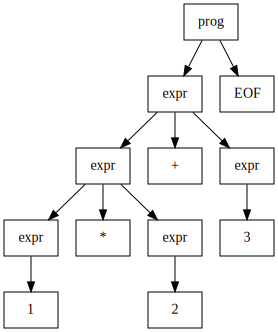

In [6]:
# @title
from graphviz import Digraph
from antlr4 import TerminalNode

def to_graphviz(parse_tree, parser, view=False):
    dot = Digraph(comment="Parse Tree")
    dot.attr('node', shape='box')

    counter = {"i": 0}

    def new_id():
        counter["i"] += 1
        return f"n{counter['i']}"

    def label_of(node):
        if isinstance(node, TerminalNode):
            # token text
            return node.getText()
        # rule context → rule name
        return parser.ruleNames[node.getRuleIndex()]

    def walk(node):
        my_id = new_id()
        dot.node(my_id, label_of(node))

        # children
        if hasattr(node, "getChildCount"):
            for i in range(node.getChildCount()):
                ch = node.getChild(i)
                ch_id = walk(ch)
                dot.edge(my_id, ch_id)
        return my_id

    walk(parse_tree)
    return dot

dot = to_graphviz(tree, parser)
dot


---

## 8. Writing Grammars: Tips

When designing grammars:

* Follow the **language specification**, not intuition
  - [Smalltalk](https://github.com/gnu-smalltalk/smalltalk) gives all binary operators equal precedence)
  - C: `>` , `<` , `>=` , `<=` higher priority than `==`, `!=`
  - Pascal: `>` , `<` , `>=` , `<=`, `==`, `!=` same priority
* Identify the **hierarchy** of language constructs. Example:

  ```
  program
    → declarations
    → statements
    → expressions
  ```
* Focus on **order and nesting**, not meaning
* Use **recursion** to express repetition and nesting

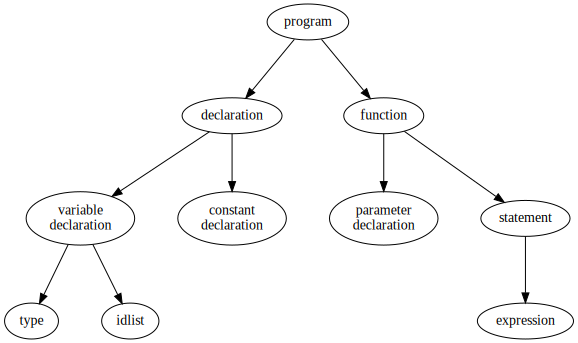

In [11]:
# @title
from graphviz import Digraph

# Create a directed graph
dot = Digraph("PL_Hierarchy", format="png")
dot.attr(rankdir="TB", splines="line", nodesep="0.6", ranksep="0.8")

# ---- Nodes ----
dot.node("program", "program")

dot.node("declaration", "declaration")
dot.node("function", "function")

dot.node("var_decl", "variable\ndeclaration")
dot.node("const_decl", "constant\ndeclaration")

dot.node("param_decl", "parameter\ndeclaration")
dot.node("statement", "statement")

dot.node("type", "type")
dot.node("idlist", "idlist")
dot.node("expression", "expression")

# ---- Edges ----
dot.edge("program", "declaration")
dot.edge("program", "function")

dot.edge("declaration", "var_decl")
dot.edge("declaration", "const_decl")

dot.edge("function", "param_decl")
dot.edge("function", "statement")

dot.edge("var_decl", "type")
dot.edge("var_decl", "idlist")

dot.edge("statement", "expression")

# ---- Ranks (to keep levels aligned nicely like your image) ----
with dot.subgraph() as s:
    s.attr(rank="same")
    s.node("declaration")
    s.node("function")

with dot.subgraph() as s:
    s.attr(rank="same")
    s.node("var_decl")
    s.node("const_decl")
    s.node("param_decl")
    s.node("statement")

with dot.subgraph() as s:
    s.attr(rank="same")
    s.node("type")
    s.node("idlist")
    s.node("expression")

dot.render("PL_Hierarchy", cleanup=True)
dot


---

## 9. One vs Many (Lists)

Many language constructs involve **lists**:

* Variable declarations
  - `a, c10, b: integer;`
* Function parameters
  - `function foo(a:integer; b:real)`
* Statement blocks
  - ```
    begin
      c := 1;
      m := 10;
    end
    ```

Use recursion to define lists:

```html
<set>    → <one_element> <subset> | <terminal_cases>
<subset> → [<separators>] <one_element> <subset> | ϵ
```

Example: This expresses “one or more identifiers separated by commas”
```
idlist → ID (',' ID)*
```


---

## 10. Nested Structures

Programming languages allow arbitrary nesting:

* Statements inside statements
* Blocks inside blocks
* Expressions inside expressions

Example: `stmt` (statements)

```
<stmt> → IF <exp> THEN <stmt> ELSE <stmt>
       | WHILE <exp> DO <stmt>
       | ...
```

Recursion naturally captures nesting.


---

## 11. EBNF and Grammar Tools

Backus-Naur form is the form you have been seeing in the previous parts.

Extended BNF (EBNF) adds RegEx operators like:

* `*` (zero or more)
* `?` (optional)
* `|` (alternation)

ANTLR directly supports EBNF-style notation:

```
expr : term (( '+' | '-' ) term)* ;
```

This improves readability and reduces ambiguity.

| Concept / Pattern        | BNF / EBNF Example                          | ANTLR Equivalent Example                          | Notes |
|---------------------------|---------------------------------------------|--------------------------------------------------|-------|
| **Terminal symbol**       | `'+'`                                       | `'+'`                                            | Same in both; quoted literal. |
| **Nonterminal reference** | `<expr>`                                    | expr                                             | Angle brackets dropped in ANTLR. |
| **Sequence**              | `<term> <factor>`                          | term factor                                      | Just space-separated in ANTLR. |
| **Choice / Alternation**  | `<digit> ::= '0' \| '1' \| '2'`               | DIGIT : '0' \| '1' \| '2' ;                        | `\|` works the same way. |
| **Optional**              | `[ <expr> ]`                               | ( expr )?                                        | `?` means zero or one occurrence. |
| **Repetition (0+)**       | `{ <digit> }`                              | DIGIT*                                           | `*` means zero or more. |
| **Repetition (1+)**       | `{ <digit> }+`                             | DIGIT+                                           | `+` means one or more. |
| **Grouping**              | `( <expr> <op> <expr> )`                   | ( expr op expr )                                 | Parentheses group subrules. |
| **Rule definition**       | `<expr> ::= <term> \| <expr> '+' <term>`     | expr : term | expr '+' term ;                     | ANTLR uses `:` and ends with `;`. |
| **Lexical rule (token)**  | `<digit> ::= '0' \| '1' \| ... \| '9'`         | DIGIT : [0-9] ;                                  | Uppercase = lexer rule. |
| **String literal**        | `"hello"`                                  | STRING : '"' .* '"' ;                            | ANTLR regex-like syntax for tokens. |
| **Whitespace / skip**     | (not standard in BNF)                      | WS : [ \t\r\n]+ -> skip ;                        | ANTLR allows actions like `-> skip`. |

---

## 12. Ambiguous Grammars

A grammar is **ambiguous** if a string has **more than one parse tree**.

Classic example:

```
INT + INT * INT
```

Is it ```(INT + INT) * INT``` or ```INT + (INT * INT)``` ?

Ambiguity makes program meaning unclear.


In [12]:
# @title
from graphviz import Digraph

def make_tree(title: str, root: str, nodes: dict, edges: list[tuple[str, str]]):
    dot = Digraph(name=title, format="png")
    dot.attr(rankdir="TB", nodesep="0.45", ranksep="0.65", splines="line")
    dot.attr("node", shape="box", style="rounded,filled", fillcolor="#cfd3ff",
             color="#6a6a6a", fontname="Helvetica", fontsize="14", margin="0.18,0.10")
    dot.attr("edge", color="#6a6a6a", arrowsize="0.75", penwidth="1.1")

    for node_id, label in nodes.items():
        dot.node(node_id, label)

    for a, b in edges:
        dot.edge(a, b)

    # Optional: keep operator node centered under root (looks nicer)
    dot.attr("node", shape="box", style="rounded,filled")
    return dot


# ---------- Tree 1: (INT + INT) * INT ----------
# Structure: exp -> exp * exp
# left exp -> exp + exp, right exp -> INT
nodes1 = {
    "e0": "<exp>",
    "e1": "<exp>", "op_mul": "MULOP", "e2": "<exp>",
    "e3": "<exp>", "op_add": "ADDOP", "e4": "<exp>",
    "i1": "INT", "i2": "INT", "i3": "INT",
}
edges1 = [
    ("e0", "e1"), ("e0", "op_mul"), ("e0", "e2"),
    ("e1", "e3"), ("e1", "op_add"), ("e1", "e4"),
    ("e3", "i1"),
    ("e4", "i2"),
    ("e2", "i3"),
]
dot1 = make_tree("tree_mul_after_add", "e0", nodes1, edges1)


# ---------- Tree 2: INT + (INT * INT) ----------
# Structure: exp -> exp + exp
# left exp -> INT, right exp -> exp * exp
nodes2 = {
    "e0": "<exp>",
    "e1": "<exp>", "op_add": "ADDOP", "e2": "<exp>",
    "e3": "<exp>", "op_mul": "MULOP", "e4": "<exp>",
    "i1": "INT", "i2": "INT", "i3": "INT",
}
edges2 = [
    ("e0", "e1"), ("e0", "op_add"), ("e0", "e2"),
    ("e1", "i1"),
    ("e2", "e3"), ("e2", "op_mul"), ("e2", "e4"),
    ("e3", "i2"),
    ("e4", "i3"),
]
dot2 = make_tree("tree_add_before_mul", "e0", nodes2, edges2)

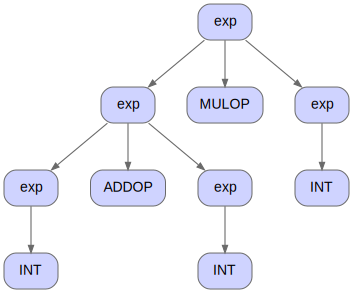

In [13]:
# (INT + INT) * INT
dot1

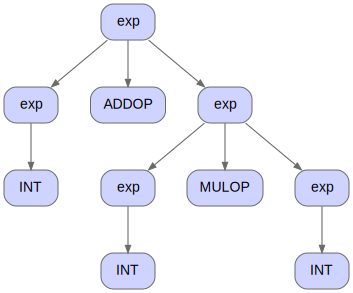

In [14]:
# INT + (INT * INT)
dot2

---

## 13. Disambiguation Techniques

### Operator Precedence

Use multiple non-terminals:

```html
Before (no priority between ADDOP or MULOP):
<exp>  → <exp> ADDOP <exp> | <exp> MULOP <exp> | INTLIT

After (prioritizing MULOP):
<exp>  → <exp> MULOP <term> | <term>
<term> → <term> ADDOP INTLIT | INTLIT
```

### Operator Associativity
The operator side where the recursive term appears will
determine the association of the operator
* Left-associative:

  ```html
  <exp> → <exp> ADDOP <term>
  ```
* Right-associative:

  ```html
  <exp> → <term> ADDOP <exp>
  ```
To priorize opterators, the left hand side (LHS) of the rules where these operators appear should be different
- *Clarify: We are referring the sides here as `LHS → RHS`*
- If operator `o1` has higher priority than operator `o2`, `o1`’s LHS is generated by `o2`’s LHS

```php
<exp>   → <exp> ADDOP <term> | <term>
<term>  → <term> MULOP <factor> | <factor>
<factor>→ INT | '(' <exp> ')'
```
Multiplication is fully grouped before addition is even considered.
- `MULOP` (higher priority) lives at `<term>`
- `ADDOP` (lower priority) lives at `<exp>`
- `<exp>` is defined using `<term>`
---

## 14. Example case: The “Dangling Else” Problem

The desired statement (`<stmt>`):
```php
IF e1 THEN IF e2 THEN s1 ELSE s2
```

...or in details:
```php
IF <exp> THEN IF <exp> THEN <other> ELSE <other>
```

Current grammar:
```php
<stmt> → IF <exp> THEN <stmt> ELSE <stmt>
       | IF <exp> THEN <stmt>
       | <other>
```

Ambiguity: which `IF` does `ELSE` match?

In [15]:
# @title
from graphviz import Digraph

def styled_dot(name: str):
    dot = Digraph(name=name, format="png")
    dot.attr(rankdir="TB", splines="line", nodesep="0.45", ranksep="0.65")
    dot.attr("node",
             shape="box",
             style="rounded,filled",
             fillcolor="#cfd3ff",
             color="#6a6a6a",
             fontname="Helvetica",
             fontsize="13",
             margin="0.18,0.10")
    dot.attr("edge", color="#6a6a6a", arrowsize="0.75", penwidth="1.1")
    return dot

def add_children(dot, parent, children):
    for ch in children:
        dot.edge(parent, ch)

# -------------------------------
# Tree A (ELSE matches OUTER IF)
# Corresponds to:
# IF e1 THEN (IF e2 THEN other) ELSE other
# -------------------------------
dotA = styled_dot("dangling_else_outer")

# nodes
dotA.node("A_s0", "<stmt>")
dotA.node("A_if1", "IF");     dotA.node("A_e1", "<exp>"); dotA.node("A_then1", "THEN")
dotA.node("A_s1", "<stmt>");  dotA.node("A_else1", "ELSE"); dotA.node("A_o2", "<other>")

dotA.node("A_if2", "IF");     dotA.node("A_e2", "<exp>"); dotA.node("A_then2", "THEN")
dotA.node("A_o1", "<other>")

# edges for outer stmt
add_children(dotA, "A_s0", ["A_if1", "A_e1", "A_then1", "A_s1", "A_else1", "A_o2"])

# edges for inner stmt (no ELSE)
add_children(dotA, "A_s1", ["A_if2", "A_e2", "A_then2", "A_o1"])

# keep IF/exp/THEN on same level visually (optional)
with dotA.subgraph() as s:
    s.attr(rank="same")
    for n in ["A_if1", "A_e1", "A_then1", "A_else1"]:
        s.node(n)

with dotA.subgraph() as s:
    s.attr(rank="same")
    for n in ["A_if2", "A_e2", "A_then2"]:
        s.node(n)

# -------------------------------
# Tree B (ELSE matches INNER IF)
# Corresponds to:
# IF e1 THEN (IF e2 THEN other ELSE other)
# -------------------------------
dotB = styled_dot("dangling_else_inner")

dotB.node("B_s0", "<stmt>")
dotB.node("B_if1", "IF");     dotB.node("B_e1", "<exp>"); dotB.node("B_then1", "THEN")
dotB.node("B_s1", "<stmt>")

dotB.node("B_if2", "IF");     dotB.node("B_e2", "<exp>"); dotB.node("B_then2", "THEN")
dotB.node("B_o1", "<other>"); dotB.node("B_else2", "ELSE"); dotB.node("B_o2", "<other>")

# edges for outer stmt (no ELSE here)
add_children(dotB, "B_s0", ["B_if1", "B_e1", "B_then1", "B_s1"])

# edges for inner stmt (has ELSE)
add_children(dotB, "B_s1", ["B_if2", "B_e2", "B_then2", "B_o1", "B_else2", "B_o2"])

with dotB.subgraph() as s:
    s.attr(rank="same")
    for n in ["B_if1", "B_e1", "B_then1"]:
        s.node(n)

with dotB.subgraph() as s:
    s.attr(rank="same")
    for n in ["B_if2", "B_e2", "B_then2", "B_else2"]:
        s.node(n)

# ---- Render files (optional) ----
dotA.render("dangling_else_outer", cleanup=True)
dotB.render("dangling_else_inner", cleanup=True)

'dangling_else_inner.png'

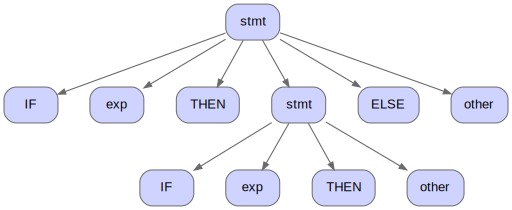

In [16]:
# Case 1: stmt first expands to 'IF...THEN...ELSE'
# IF <exp> THEN (IF <exp> THEN <other>) ELSE <other>
dotA

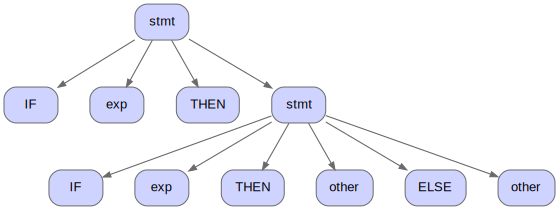

In [17]:
# Case 2: stmt first expands to 'IF...THEN'
# IF <exp> THEN (IF <exp> THEN <other> ELSE <other>)
dotB

<img src="https://github.com/tuankhoin/CO3005-PPL/blob/main/assets/dllt_disapprove.png?raw=true" alt="drawing" width="200"/>

Solution: separate **matched** and **unmatched** statements:

```
stmt → matched | unmatched
```

```php
<stmt>        → <matchStmt>
              | <unmatchStmt>

<matchStmt>   → IF <exp> THEN <matchStmt> ELSE <matchStmt>
              | <other>

<unmatchStmt> → IF <exp> THEN <stmt>
              | IF <exp> THEN <matchStmt> ELSE <unmatchStmt>
```

This removes ambiguity and matches real language behavior:
> Because the `ELSE` must attach to the nearest unmatched `IF`, the inner `IF` becomes a `<matchStmt>`, and the outer statement becomes an `<unmatchStmt>` of the form `IF <exp> THEN <stmt>`

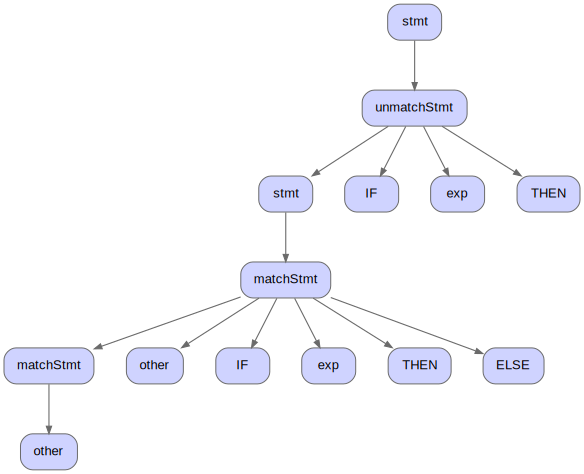

In [18]:
# @title
from graphviz import Digraph

def make_dot(name: str):
    dot = Digraph(name=name, format="png")
    dot.attr(rankdir="TB", splines="line", nodesep="0.45", ranksep="0.70")
    dot.attr("node",
             shape="box",
             style="rounded,filled",
             fillcolor="#cfd3ff",
             color="#6a6a6a",
             fontname="Helvetica",
             fontsize="13",
             margin="0.18,0.10")
    dot.attr("edge", color="#6a6a6a", arrowsize="0.75", penwidth="1.1")
    return dot

def edge_children(dot, parent, children):
    for ch in children:
        dot.edge(parent, ch)

dot = make_dot("unambiguous_dangling_else")

# ---- Non-terminals ----
dot.node("S_stmt0", "<stmt>")
dot.node("S_un0", "<unmatchStmt>")

dot.node("S_stmt1", "<stmt>")
dot.node("S_match0", "<matchStmt>")

dot.node("S_match1", "<matchStmt>")
dot.node("S_other1", "<other>")
dot.node("S_other2", "<other>")

# ---- Terminals / tokens ----
dot.node("T_if1", "IF")
dot.node("T_e1", "<exp>")
dot.node("T_then1", "THEN")

dot.node("T_if2", "IF")
dot.node("T_e2", "<exp>")
dot.node("T_then2", "THEN")
dot.node("T_else2", "ELSE")

# ---- Structure according to the unambiguous grammar ----
# <stmt> -> <unmatchStmt>
edge_children(dot, "S_stmt0", ["S_un0"])

# <unmatchStmt> -> IF <exp> THEN <stmt>
edge_children(dot, "S_un0", ["T_if1", "T_e1", "T_then1", "S_stmt1"])

# <stmt> -> <matchStmt>
edge_children(dot, "S_stmt1", ["S_match0"])

# <matchStmt> -> IF <exp> THEN <matchStmt> ELSE <matchStmt>
edge_children(dot, "S_match0", ["T_if2", "T_e2", "T_then2", "S_match1", "T_else2", "S_other2"])

# Left <matchStmt> -> <other>
edge_children(dot, "S_match1", ["S_other1"])

# Keep some tokens aligned per level (optional, for nicer layout)
with dot.subgraph() as s:
    s.attr(rank="same")
    for n in ["T_if1", "T_e1", "T_then1"]:
        s.node(n)

with dot.subgraph() as s:
    s.attr(rank="same")
    for n in ["T_if2", "T_e2", "T_then2", "T_else2"]:
        s.node(n)

# Render file + display inline in notebooks
dot.render("unambiguous_dangling_else", cleanup=True)
dot


<img src="https://github.com/tuankhoin/CO3005-PPL/blob/main/assets/dllt_approve.png?raw=true" alt="drawing" width="200"/>


---

## 15. Disambiguation in ANTLR

ANTLR provides **associativity and precedence declarations**:

```php
expr
  : expr MULOP expr                   // highest priority
  | expr ADDOP expr
  | <assoc=right> expr '=' expr       // lowest priority
  | INT
  | ID
  ;

(Default is left-associated unless you use <assoc=right>)
```

ANTLR resolves ambiguity using rule order and associativity annotations.

---

## 16. What Syntax Analysis Can and Cannot Do

CFGs can describe:

* Order of tokens
* Nesting structure
* Operator precedence and associativity

CFGs cannot enforce **constraints**:

* Type rules
* Scope and name binding
* Context-sensitive constraints

Those belong to **semantic analysis**.

---

## 17. Summary

* Syntax analysis determines **structural correctness**
* Programming languages require **context-free grammars**
* Parse trees capture hierarchical structure
* Ambiguity must be resolved explicitly
* Grammar design strongly affects compiler correctness and clarity
